In [92]:
import datetime

In [ ]:
import colorsys

In [144]:
import os
import pandas as pd
import re
import numpy as np
from ast import literal_eval
from collections import Counter
import sys
import pprint
import networkx as nx
import pygraphviz
from networkx.drawing.nx_agraph import graphviz_layout
%matplotlib inline
import matplotlib.pyplot as plt

In [31]:
import preprocess as prep

In [2]:
DATA_DIR = os.getenv("DATA_DIR")
filename = "preprocessed_with_dupes_31_10_taxon2.csv.gz"
path = os.path.join(DATA_DIR,"output", filename)

In [3]:
df = pd.read_csv(path,sep="\t",compression="gzip")

In [4]:
df.shape

(1174770, 17)

In [5]:
df.columns

Index(['Occurrences', 'DeviceCategories', 'PageSeq_Length', 'Actions_Length',
       'Dates', 'Sequence', 'PageSequence', 'Page_Event_List', 'Page_List',
       'Event_List', 'num_event_cats', 'Event_cats_agg', 'Event_cat_act_agg',
       'Taxon_List', 'Taxon_Page_List', 'Page_List_NL', 'Page_Seq_NL'],
      dtype='object')

In [6]:
any(df.Sequence.duplicated())

False

In [7]:
for col in df.columns:
    if "Sequence" not in col:
        if isinstance(df[col].iloc[0],str) and "[" in df[col].iloc[0]:
            print(col)
            df[col] = df[col].map(literal_eval)

DeviceCategories
Dates
Page_Event_List
Page_List
Event_List
Event_cats_agg
Event_cat_act_agg
Taxon_List
Taxon_Page_List
Page_List_NL


### Detect duplicate `Sequence` values, very bizarre BigQuery behavior
Difference between `Action_Length` values, will ignore for now

In [8]:
# seq = df["Sequence"]
# df[seq.isin(seq[seq.duplicated()])].sort_values(by="Sequence")
# df[seq.isin(seq[seq.duplicated()])].sort_values(by="Sequence")[0:3][['Actions_Length','Sequence']].values
# line = '/1619-bursary-fund<<PAGE<:<NULL<:<NULL<<64aa6eec-48b5-481d-9131-9c8b6326eea1>>/1619-bursary-fund<<EVENT<:<contentsClicked<:<next<<64aa6eec-48b5-481d-9131-9c8b6326eea1>>/1619-bursary-fund/what-youll-get<<PAGE<:<NULL<:<NULL<<64aa6eec-48b5-481d-9131-9c8b6326eea1>>/1619-bursary-fund/eligibility<<PAGE<:<NULL<:<NULL<<64aa6eec-48b5-481d-9131-9c8b6326eea1>>/1619-bursary-fund/eligibility<<EVENT<:<contentsClicked<:<next<<64aa6eec-48b5-481d-9131-9c8b6326eea1>>/1619-bursary-fund/how-to-claim<<PAGE<:<NULL<:<NULL<<64aa6eec-48b5-481d-9131-9c8b6326eea1'

# len(line.split(">>"))

## Count taxons within journeys
### Setup

In [9]:
def unique_taxon_flat_unique(taxon_list):
    return sum(Counter(set([t for taxon in taxon_list for t in taxon.split(",")])).values())
def unique_taxon_nested_unique(taxon_list):
    return sum(Counter(set([taxon for taxon in taxon_list])).values())
def unique_taxon_flat_pages(taxon_list):
    return sum(Counter([t for taxon in taxon_list for t in taxon.split(",")]).values())
def unique_taxon_nested_pages(taxon_list):
    return sum(Counter([taxon for taxon in taxon_list]).values())

In [10]:
df.iloc[0].Sequence

'/log-in-file-self-assessment-tax-return<<PAGE<:<NULL<:<NULL<<895732d7-177b-4def-8997-f1afc4364415,3564cf4e-506c-42fa-bdd3-e95e7908645f>>/log-in-file-self-assessment-tax-return/sign-in/prove-identity<<PAGE<:<NULL<:<NULL<<other>>/log-in-file-self-assessment-tax-return/sign-in/prove-identity<<EVENT<:<Radio button chosen<:<sign-in-with-government-gateway<<other>>/log-in-file-self-assessment-tax-return<<PAGE<:<NULL<:<NULL<<895732d7-177b-4def-8997-f1afc4364415,3564cf4e-506c-42fa-bdd3-e95e7908645f>>/log-in-file-self-assessment-tax-return/sign-in/prove-identity<<PAGE<:<NULL<:<NULL<<other>>/log-in-file-self-assessment-tax-return/sign-in/prove-identity<<EVENT<:<Radio button chosen<:<sign-in-with-government-gateway<<other'

In [11]:
target = df.Taxon_List.iloc[1]
print(target)
print(unique_taxon_flat_unique(target))
print(unique_taxon_nested_unique(target))
print(unique_taxon_flat_pages(target))
print(unique_taxon_nested_pages(target))

['d1e5dcf5-5f36-4838-bcb6-f0068eddb8a7,1de432b7-2331-4450-9667-374d56e7f084', '1de432b7-2331-4450-9667-374d56e7f084']
2
2
3
2


In [12]:
df['taxon_flat_unique'] = df['Taxon_List'].map(unique_taxon_flat_unique)
df['taxon_nested_unique'] = df['Taxon_List'].map(unique_taxon_nested_unique)
df['taxon_flat_pages'] = df['Taxon_List'].map(unique_taxon_flat_pages)
df['taxon_nested_pages'] = df['Taxon_List'].map(unique_taxon_nested_pages)

In [13]:
df.describe().drop("count").applymap(lambda x: format(x,"f"))

,Occurrences,PageSeq_Length,Actions_Length,num_event_cats,taxon_flat_unique,taxon_nested_unique,taxon_flat_pages,taxon_nested_pages
mean,1.629866,6.119780,9.921242,3.163181,3.485444,2.278085,10.083453,6.117189
std,61.457057,6.995605,11.010500,1.609643,2.979700,1.427140,12.926314,6.994359
min,1.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,3.000000,4.000000,2.000000,2.000000,1.000000,4.000000,3.000000
50%,1.000000,4.000000,7.000000,3.000000,3.000000,2.000000,6.000000,4.000000
75%,1.000000,7.000000,12.000000,4.000000,4.000000,3.000000,12.000000,7.000000
max,55840.000000,500.000000,500.000000,21.000000,429.000000,215.000000,979.000000,500.000000


In [14]:
df.describe().drop("count").applymap(lambda x: '%.2f' % x)

,Occurrences,PageSeq_Length,Actions_Length,num_event_cats,taxon_flat_unique,taxon_nested_unique,taxon_flat_pages,taxon_nested_pages
mean,1.63,6.12,9.92,3.16,3.49,2.28,10.08,6.12
std,61.46,7.00,11.01,1.61,2.98,1.43,12.93,6.99
min,1.00,2.00,2.00,1.00,0.00,0.00,0.00,0.00
25%,1.00,3.00,4.00,2.00,2.00,1.00,4.00,3.00
50%,1.00,4.00,7.00,3.00,3.00,2.00,6.00,4.00
75%,1.00,7.00,12.00,4.00,4.00,3.00,12.00,7.00
max,55840.00,500.00,500.00,21.00,429.00,215.00,979.00,500.00


In [15]:
df[df.taxon_flat_unique == 429].Taxon_List.values

array([list(['9545e449-c2cc-4f1c-b668-4b9b0762e054,b859689f-e569-4a1c-8b36-866f43c31aed', 'ba7d476d-ac4e-40a3-81f4-353842bf5b73,5cde1752-6876-4ac5-b88c-41122f0d9f1a', 'c312aabc-1f97-436c-94a4-60a848410c8c,3edf94b1-cc0c-44c6-99b4-8385e9699541', '79e5711d-5537-4d06-a3e9-c10a830456a1,44b9efd9-3998-48b6-9373-581717b90200', '291c1c0e-0e08-4199-99ac-9ddfa4294f79,c4795562-0e23-44d0-a1ab-4755c120d1ee', 'b204942a-853a-456e-8eda-f2b98b305ba0,422796b0-81cc-40f7-8c4d-add182e9b153', 'bcb51bee-fed0-44df-83be-1b3059e8542a,a4b86b2d-9263-48fd-9183-b99c67a8109b', 'e7d7876c-e8ec-404a-a780-f610eab61abb,b5ea5066-6972-4e5b-ad77-90d88a8561cc', '613a04d2-b1be-4bc3-9e73-4c6d5c36f075,c501dc62-2cbe-48d8-8fda-78971bcb8179', '0dc17433-40d9-454e-90fe-ea4a4cfaf490,65287b3f-1c2e-4a92-8835-fcea6f5317fa', 'b2801c90-89c6-4e17-b3cc-df7346b07ebc,5bd44bc3-a8be-474e-bc5c-6a16cfffd80f', '60e1dedb-60aa-4063-8631-714db2810fd8,07336987-42d7-4420-854f-dbca674fac85', 'dfabb10b-f8a8-4eeb-a6fb-309b0522cafb,12e40a23-d459-4c1c-bfaa-9

In [16]:
df[df.taxon_flat_unique == 0].Sequence.values

array(['/vehicle-tax<<EVENT<:<browser-check<:<prompt-shown<<1de432b7-2331-4450-9667-374d56e7f084>>/vehicle-tax<<EVENT<:<browser-check<:<prompt-shown<<1de432b7-2331-4450-9667-374d56e7f084>>/vehicle-tax<<EVENT<:<browser-check<:<prompt-shown<<1de432b7-2331-4450-9667-374d56e7f084>>/vehicle-tax<<EVENT<:<browser-check<:<prompt-shown<<1de432b7-2331-4450-9667-374d56e7f084',
       '/contact-ukvi-inside-outside-uk<<<PAGE<:<NULL<:<NULL<<other>>/contact-ukvi-inside-outside-uk<<<PAGE<:<NULL<:<NULL<<other>>/contact-ukvi-inside-outside-uk<<<PAGE<:<NULL<:<NULL<<other',
       '/vehicle-tax<<EVENT<:<browser-check<:<prompt-shown<<1de432b7-2331-4450-9667-374d56e7f084>>/vehicle-tax<<EVENT<:<browser-check<:<prompt-shown<<1de432b7-2331-4450-9667-374d56e7f084'],
      dtype=object)

In [17]:
def taxon_split(taxon_list):
    return [t for taxon in taxon_list for t in taxon.split(",")]

In [18]:
#### Build list of unique taxons, excluding "other"
taxon_counter = Counter()
for tup in df.itertuples():
    taxons = taxon_split(tup.Taxon_List)
    for taxon in taxons:
        taxon_counter[taxon]+=1
len(taxon_counter)            

2452

In [19]:
list(taxon_counter.keys())[0:10]

['895732d7-177b-4def-8997-f1afc4364415',
 '3564cf4e-506c-42fa-bdd3-e95e7908645f',
 'other',
 'd1e5dcf5-5f36-4838-bcb6-f0068eddb8a7',
 '1de432b7-2331-4450-9667-374d56e7f084',
 '21bfd8f6-3360-43f9-be42-b00002982d70',
 '62fcbba5-3a75-4d15-85a6-d8a80b03d57c',
 '0fffa994-b76d-4539-8bf9-2a6c6751580d',
 '1f3d1ae8-aba7-4e02-abbc-6b54e6ff66aa',
 '6126d57d-df55-4f31-86ec-6d4388b513b1']

In [20]:
taxon_counter.most_common(10)

[('other', 1900273),
 ('d1e5dcf5-5f36-4838-bcb6-f0068eddb8a7', 254766),
 ('1de432b7-2331-4450-9667-374d56e7f084', 213517),
 ('ebeaf804-c1b1-40cd-920f-319aa2b56ba3', 205626),
 ('05a9527b-e6e9-4a68-8dd7-7d84e6a24eef', 189059),
 ('104ee859-8278-406b-80cb-5727373e0198', 186285),
 ('536f83c0-8c67-47a3-88a4-d5b1eda591ed', 183216),
 ('2a1bd1b1-5025-4313-9e5b-8352dd46f1d6', 162677),
 ('a7f3005b-a3cd-4060-a127-725accb54f2e', 158150),
 ('29480b00-dc4d-49a0-b48c-25dda8569325', 148155)]

#### Map taxon `content_id` to `base_path` using content tagger extract

In [21]:
taxon_path = os.path.join(os.getenv("DOCUMENTS"),"taxons.json.gz")
taxon_df = pd.read_json(taxon_path,compression="gzip")

In [22]:
# taxon_path = os.path.join(os.path.dirname(os.getenv("DOCUMENTS")), "Downloads", "2018-11-19 Taxonomy.csv")
# taxon_df = pd.read_csv(taxon_path)

In [23]:
taxon_df

,base_path,content_id,parent_content_id,title
0,/education,c58fdadd-7743-46d6-9629-90bb3ccc4ef0,NaN,"Education, training and skills"
1,/defence,e491505c-77ae-45b2-84be-8c94b94f6a2b,NaN,Defence
2,/life-circumstances,20086ead-41fc-49cf-8a62-d4e1126f41fc,NaN,Life circumstances
3,/money,6acc9db4-780e-4a46-92b4-1812e3c2c48a,NaN,Money
4,/government/all,e48ab80a-de80-4e83-bf59-26316856a5f9,NaN,Government
5,/childcare-parenting,206b7f3a-49b5-476f-af0f-fd27e2a68473,NaN,"Parenting, childcare and children's services"
6,/regional-and-local-government,503c5bc7-809a-47b9-83e2-bd0c212dbabb,NaN,Regional and local government
7,/employment,d0f1e5a3-c8f4-4780-8678-994f19104b21,NaN,Work
8,/entering-staying-uk,ba3a9702-da22-487f-86c1-8334a730e559,NaN,Entering and staying in the UK
9,/corporate-information,a544d48b-1e9e-47fb-b427-7a987c658c14,NaN,Corporate information


In [24]:
taxon_df.shape

(1952, 4)

In [25]:
taxon_df.columns

Index(['base_path', 'content_id', 'parent_content_id', 'title'], dtype='object')

In [26]:
## Count parent taxon,self-parenting if nan
counter =0
parent_taxons = Counter()
for taxon,value in taxon_counter.items():
    temp = taxon_df[taxon_df.content_id==taxon]
    if temp.shape[0]>0:
        taxon_base_path = temp.iloc[0].base_path
        parent = None
        if isinstance(temp.iloc[0].parent_content_id,str):
            parent = taxon_df[taxon_df.content_id == temp.iloc[0].parent_content_id].iloc[0].title
        else:
            parent = temp.iloc[0].title
        parent_taxons[parent]+=value
#         print("{}, {}, \nParent: {}\n=====".format(taxon,taxon_base_path,parent))
#     else:
#         print("not found:",taxon,value)
#         counter+=1
# print(counter)

In [27]:
list(parent_taxons.most_common(30))

[('Welfare', 1236239),
 ('Vehicle ownership, approval and standards', 671042),
 ('Working, jobs and pensions', 597467),
 ('Personal tax', 449094),
 ('Life circumstances', 262701),
 ('Work', 255293),
 ('Business tax', 232142),
 ('Entering and staying in the UK', 219812),
 ('Money', 211800),
 ('Income Tax', 207100),
 ('Going and being abroad', 206183),
 ('Business', 191590),
 ('Financial help if you have children', 186533),
 ('Visas and entry clearance', 186528),
 ('Driving licences', 154468),
 ('Government', 151468),
 ('Funding and finance for students', 147556),
 ('Marriage, civil partnership and divorce', 143355),
 ('Disabled people', 141495),
 ('Dealing with HMRC', 139396),
 ('Crime, justice and law', 136132),
 ('Self-employment', 135378),
 ('Employing people', 132659),
 ('Housing', 132016),
 ('Driving and motorcycle tests', 128843),
 ('Permanent stay in the UK', 121124),
 ('Self Assessment', 118495),
 ('Business and enterprise', 112025),
 ('Divorce, separation and legal issues', 104

In [28]:
len(parent_taxons)

222

In [29]:
### Assign unique parent taxons per journey

In [30]:
src = os.path.join(os.path.dirname(DATA_DIR),"src")
sys.path.append(os.path.join(src, "data"))

In [32]:
df['subpaths'] = df['Page_List'].map(prep.subpaths_from_list)

In [33]:
df['Taxon_Page_List'].iloc[0]

[('/log-in-file-self-assessment-tax-return',
  ('895732d7-177b-4def-8997-f1afc4364415',
   '3564cf4e-506c-42fa-bdd3-e95e7908645f')),
 ('/log-in-file-self-assessment-tax-return/sign-in/prove-identity',
  ('other',)),
 ('/log-in-file-self-assessment-tax-return',
  ('895732d7-177b-4def-8997-f1afc4364415',
   '3564cf4e-506c-42fa-bdd3-e95e7908645f')),
 ('/log-in-file-self-assessment-tax-return/sign-in/prove-identity',
  ('other',))]

In [34]:
### create new subpaths where each element is a (page,parent taxon pair, pick one?)

In [35]:
def get_taxon_name(taxon_id):
    if taxon_id in taxon_df.content_id.values:
        return taxon_df[taxon_df.content_id==taxon_id].iloc[0].title
    else:
        return None

In [36]:
def taxon_title(taxon_id_list):
    return [get_taxon_name(taxon_id) for taxon_id in taxon_id_list]

In [37]:
def subpaths_from_pcd_list(pcd_list):
    return [[(page,taxon_title(taxons)), (pcd_list[i + 1][0],taxon_title(pcd_list[i + 1][1]))] 
            for i, (page,taxons) in enumerate(pcd_list) if i < len(pcd_list) - 1]

In [38]:
test_journey = df[df.PageSeq_Length>4].iloc[0]

In [39]:
pprint.pprint([p for p,_ in test_journey.Taxon_Page_List])

['/government/organisations/disclosure-and-barring-service',
 '/government/organisations/disclosure-and-barring-service',
 '/make-a-freedom-of-information-request',
 '/government/publications?departments[]=disclosure-and-barring-service&publication_type=foi-releases',
 '/government/publications/number-of-dbs-checks-issued-and-the-percentage-that-show-information']


In [40]:
for i,element in enumerate(subpaths_from_pcd_list(test_journey.Taxon_Page_List)):
    print(i,element,"\n====")

0 [('/government/organisations/disclosure-and-barring-service', [None]), ('/government/organisations/disclosure-and-barring-service', [None])] 
====
1 [('/government/organisations/disclosure-and-barring-service', [None]), ('/make-a-freedom-of-information-request', ['Your rights and the law'])] 
====
2 [('/make-a-freedom-of-information-request', ['Your rights and the law']), ('/government/publications?departments[]=disclosure-and-barring-service&publication_type=foi-releases', [None])] 
====
3 [('/government/publications?departments[]=disclosure-and-barring-service&publication_type=foi-releases', [None]), ('/government/publications/number-of-dbs-checks-issued-and-the-percentage-that-show-information', ['Government efficiency, transparency and accountability'])] 
====


In [41]:
# df['taxon_subpaths'] = df['Taxon_Page_List'].map(subpaths_from_pcd_list)

In [42]:
## graph some stuff based on taxon (parent?)

In [50]:
taxon_title(df.Taxon_Page_List.iloc[0][0][1])

['Filing a tax return', 'Self Assessment']

In [75]:
def add_to_taxon_dict(diction,taxon_list):
    for taxon in taxon_list:
        print(taxon)
        if taxon not in diction.keys():
            diction[taxon] = get_taxon_name(taxon)

In [54]:
df.Taxon_Page_List.iloc[0][0][1]

('895732d7-177b-4def-8997-f1afc4364415',
 '3564cf4e-506c-42fa-bdd3-e95e7908645f')

In [55]:
df.Taxon_Page_List.iloc[0][1][1]

('other',)

In [56]:
taxon_name = {}
add_to_taxon_dict(taxon_name,df.Taxon_Page_List.iloc[0][0][1]+df.Taxon_Page_List.iloc[0][1][1])

In [57]:
taxon_name

{'895732d7-177b-4def-8997-f1afc4364415': 'Filing a tax return',
 '3564cf4e-506c-42fa-bdd3-e95e7908645f': 'Self Assessment',
 'other': None}

In [72]:
df.shape

(1174770, 22)

In [80]:
def add_page_taxon(diction,key,value):
    if key not in diction.keys():
        diction[key] = value

In [96]:
print(datetime.datetime.now().strftime("[%H:%M:%S]"))

[12:10:27]


In [142]:
#### Graph viz

In [146]:
adjacency_list = {}
adjacency_counter = Counter()
freq_filter = 1000
dupe_count = 0
page_taxon_title = {}

for i,tup in enumerate(df.sort_values(by="Occurrences",ascending=False).itertuples()):
#     for page,taxon in tup.Taxon_Page_List:
    for subpath in subpaths_from_pcd_list(tup.Taxon_Page_List):
        start = subpath[0][0]
        end = subpath[1][0]
#         print(subpath[0][1]+subpath[1][1])
        adjacency_counter [(start,end)] += tup.Occurrences
        
        
        if start!=end and adjacency_counter[(start,end)] >= freq_filter:
            
            add_page_taxon(page_taxon_title,start,subpath[0][1])
            add_page_taxon(page_taxon_title,end,subpath[1][1])
          

            if start in adjacency_list.keys():
                if end not in adjacency_list[start]:
                    adjacency_list[start].append(end)
            else:
                adjacency_list[start] = [end]
                
    if len(adjacency_list)>1000:
        break
            
    if i%30000==0:
        print(datetime.datetime.now().strftime("[%H:%M:%S]"),"ind",i)
        print(len(adjacency_list))

[12:46:21] ind 0
1
[12:48:12] ind 30000
69
[12:50:09] ind 60000
75
[12:52:48] ind 90000
79
[12:56:14] ind 120000
80
[13:02:45] ind 150000
84
[13:10:40] ind 180000
91
[13:13:35] ind 210000
96
[13:18:13] ind 240000
99
[13:25:31] ind 270000
107
[13:31:15] ind 300000
112
[13:38:36] ind 330000
117
[13:43:20] ind 360000
124


KeyboardInterrupt: 

In [147]:
len(adjacency_list)

128

In [148]:
list(adjacency_list.items())[0:10]

[('/government/organisations/companies-house',
  ['/get-information-about-a-company',
   '/file-an-annual-return-with-companies-house',
   '/file-your-company-annual-accounts',
   '/file-changes-to-a-company-with-companies-house']),
 ('/done/vehicle-tax',
  ['/contact/govuk/anonymous-feedback/thankyou', '/', '/vehicle-tax']),
 ('/government/organisations/hm-revenue-customs',
  ['/log-in-register-hmrc-online-services',
   '/topic/business-tax/vat',
   '/topic/personal-tax/self-assessment',
   '/topic/personal-tax/income-tax']),
 ('/universal-credit',
  ['/sign-in-universal-credit',
   '/universal-credit/eligibility',
   '/universal-credit/how-to-claim']),
 ('/personal-tax-account', ['/personal-tax-account/sign-in/prove-identity']),
 ('/vehicle-tax',
  ['/make-a-sorn',
   '/check-vehicle-tax',
   '/done/vehicle-tax',
   '/car-tax-disc-without-v11-reminder',
   '/browse/driving/vehicle-tax-mot-insurance',
   '/vehicle-tax-direct-debit']),
 ('/contact/govuk/anonymous-feedback/thankyou', ['

In [149]:
list(page_taxon_title.items())[0:10]

[('/government/organisations/companies-house', [None]),
 ('/get-information-about-a-company', ['Business debt and bankruptcy']),
 ('/done/vehicle-tax', [None]),
 ('/contact/govuk/anonymous-feedback/thankyou', [None]),
 ('/government/organisations/hm-revenue-customs', [None]),
 ('/log-in-register-hmrc-online-services', ['Paying HMRC']),
 ('/universal-credit',
  ['Benefits entitlement',
   'Benefits for families',
   'Carers and disability benefits',
   'Child Benefit (welfare theme)',
   'Heating and housing benefits',
   "Jobseeker's Allowance and low income benefits",
   'Tax credits',
   'Universal Credit']),
 ('/sign-in-universal-credit', ['Benefits entitlement', 'Universal Credit']),
 ('/personal-tax-account', ['Dealing with HMRC', 'Income Tax']),
 ('/personal-tax-account/sign-in/prove-identity', [None])]

In [150]:
for page,taxons in page_taxon_title.items():
    page_taxon_title[page] = "_".join([taxon if taxon is not None else "None" for taxon in taxons])   

In [151]:
N = len(page_taxon_title.values())
HSV_tuples = [(x*1.0/N, 0.5, 0.5) for x in range(N)]
RGB_tuples = map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples)
RGB_tuples = list(RGB_tuples)

In [152]:
taxon_color = {taxon:RGB_tuples[i] for i,taxon in enumerate(page_taxon_title.values())}

In [153]:
digraph = nx.DiGraph()

In [154]:
for node,out_nodes in adjacency_list.items():
    color = taxon_color[page_taxon_title[node]]
    digraph.add_node(node,taxon=page_taxon_title[node],color=color)
    for o_node in out_nodes:
        color = taxon_color[page_taxon_title[o_node]]
        digraph.add_node(o_node,taxon=page_taxon_title[o_node],color=color)
        digraph.add_edge(node,o_node)

In [155]:
digraph.edges()

OutEdgeView([('/government/organisations/companies-house', '/get-information-about-a-company'), ('/government/organisations/companies-house', '/file-an-annual-return-with-companies-house'), ('/government/organisations/companies-house', '/file-your-company-annual-accounts'), ('/government/organisations/companies-house', '/file-changes-to-a-company-with-companies-house'), ('/get-information-about-a-company', '/government/organisations/companies-house'), ('/file-an-annual-return-with-companies-house', '/government/organisations/companies-house'), ('/done/vehicle-tax', '/contact/govuk/anonymous-feedback/thankyou'), ('/done/vehicle-tax', '/'), ('/done/vehicle-tax', '/vehicle-tax'), ('/contact/govuk/anonymous-feedback/thankyou', '/'), ('/contact/govuk/anonymous-feedback/thankyou', '/done/vehicle-tax'), ('/', '/browse/benefits'), ('/', '/jobsearch'), ('/', '/personal-tax-account'), ('/', '/search?q=universal+credit'), ('/', '/vehicle-tax'), ('/', '/browse/driving'), ('/', '/contact/govuk/anon

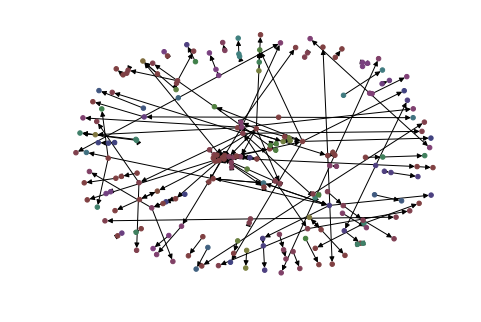

In [161]:
edges = digraph.edges()
color_map = [data['color'] for _,data in digraph.nodes(data=True)]

# pos = nx.nx_agraph.graphviz_layout(digraph, prog='neato')

nx.draw_spring(digraph,  node_size=20, fontsize=12, edges=edges, node_color=color_map)
# plt.savefig("example.png",format="PNG")
plt.show()


# 

# ### ALWAYS AFTER POS INSTANTIATION, COME ON
# pos_higher = {}
# y_off = 2  # offset on the y axis
# for k, v in pos.items():
#     pos_higher[k] = (v[0], v[1]+y_off)
    
# nx.draw(functional, pos, node_size=40,  fontsize=12, edges=edges, edge_color=colors, node_color=color_map)
# nx.draw_networkx_labels(functional, pos_higher, labels)
# plt.savefig(os.path.join(IMAGES,"eu_settled_most_frequent_"+str(freq_filter)+\
#                          "_color_pub_no_intercept_generic_search_defined.png"), format="PNG")